In [1]:
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media
import pandas as pd
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('/Users/kinoshitashouhei/Desktop/python_practice/work_knowledge/light_weight_mmm/')

### データの読み込み

In [3]:
# データの読み込み
df = pd.read_excel("Sr+Advertising+Analyst+Work+Sample.xlsx")

In [4]:
df.head(3)

,Date,Brand Alias,Ad group alias,ASIN/SKU Alias,Marketplace,Impressions,Clicks,Spend,Sales,Orders,Units,Advertised Units sold,Other SKU units sold,Advertised SKU Sales,Other SKU sales
0,2021-10-17,Brand 1,Brand 1 Ad Group 10,ASIN414,Walmart,33,0,0.0,0.0,0,0,0,0,0.0,0.0
1,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN385,Walmart,0,0,0.0,0.0,0,0,0,0,0.0,0.0
2,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN389,Walmart,0,0,0.0,0.0,0,0,0,0,0.0,0.0


In [5]:
# 動作確認のため、チャンネルは5つのみ使用
list_media = [f'Brand 1 Ad Group {i}' for i in range(1, 6)]
df = df[df['Ad group alias'].isin(list_media)].reset_index(drop=True)

In [6]:
df.groupby(["Marketplace"])[["Impressions","Spend", "Sales",]].sum()

,Impressions,Spend,Sales
Marketplace,,,
Amazon,12025234,15301.050,159399.4125
Ebay,12906745,16154.480,129957.5300
Walmart,12372336,18341.352,127869.0900


### 前処理(目標としては、学習データの形式の日付単位のデータを作成)

In [7]:
# IMPをベースにしたMediaデータ、事前分布としてのCostデータ、KPIのSalesデータを作成
agg_data = df.groupby(["Date", "Ad group alias"])[["Impressions","Spend", "Sales",]].sum()
agg_data.head(10)

Impressions    Spend      Sales
Date       Ad group alias                                     
2021-10-17 Brand 1 Ad Group 1         3317   10.650   454.8875
           Brand 1 Ad Group 2        40265  228.334  4105.9775
           Brand 1 Ad Group 3            0    0.000     0.0000
           Brand 1 Ad Group 4       142704  157.510  1169.7300
           Brand 1 Ad Group 5           55    3.638    79.9675
2021-10-18 Brand 1 Ad Group 1         1501   12.220   264.1775
           Brand 1 Ad Group 2        18545   70.360  1156.0425
           Brand 1 Ad Group 4       389663  294.624  1762.4325
           Brand 1 Ad Group 5           53    3.004   161.2000
2021-10-19 Brand 1 Ad Group 1          771    5.340   192.4500

In [8]:
# Mediaデータ作成
media_data_raw = agg_data['Impressions'].unstack().fillna(0)
media_data_raw.head()

Ad group alias,Brand 1 Ad Group 1,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5
Date,,,,,
2021-10-17,3317.0,40265.0,0.0,142704.0,55.0
2021-10-18,1501.0,18545.0,0.0,389663.0,53.0
2021-10-19,771.0,13078.0,0.0,810070.0,58.0
2021-10-20,958.0,10743.0,0.0,821705.0,60.0
2021-10-21,1841.0,10799.0,0.0,1241204.0,72.0


In [9]:
# Costデータ作成
costs_raw = agg_data['Spend'].unstack()
costs_raw.head()

Ad group alias,Brand 1 Ad Group 1,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5
Date,,,,,
2021-10-17,10.65,228.334,0.0,157.510,3.638
2021-10-18,12.22,70.360,NaN,294.624,3.004
2021-10-19,5.34,35.470,NaN,683.690,2.710
2021-10-20,9.39,35.308,NaN,962.408,5.962
2021-10-21,10.12,84.106,NaN,1836.684,6.224


In [10]:
# Salesデータ作成
sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()
sales_raw.head()

,Sales
Date,
2021-10-17,5810.5625
2021-10-18,3343.8525
2021-10-19,5864.8700
2021-10-20,4131.3425
2021-10-21,9107.2475


### バリデーション

In [11]:
split_point = pd.Timestamp("2021-12-15")

media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1,'D')]
media_data_test = media_data_raw.loc[split_point:]

target_train = sales_raw.loc[:split_point - pd.Timedelta(1,'D')]
target_test = sales_raw.loc[split_point:]

costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

### 前処理(スケーリング)

In [12]:
# NOTE: ベイズは一般的にスケーリングする必要がある。ただし、スケーリング後は非負の値にするべき
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train.values)
costs_scaled = cost_scaler.fit_transform(costs_train.values)

media_data_test_scaled = media_scaler.transform(media_data_test.values)

# 説明変数の列名をリストで取得しておく
media_names = media_data_raw.columns

### 学習、予測

In [13]:
# NOTE: model_nameは【adstock or hill_adstock or carryover】のいずれか。
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

mmm.fit(media=media_data_train_scaled,
        media_prior=costs_scaled,
        target=target_train_scaled,
        number_warmup=1000,
        number_samples=1000,
        number_chains=1,
        degrees_seasonality=3,
        weekday_seasonality=True,
        seasonality_frequency=365,
        seed=1)

sample: 100%|██████████| 2000/2000 [01:13<00:00, 27.07it/s, 1023 steps of size 2.59e-03. acc. prob=0.95]


In [14]:
# 予測、評価(MAPE)
prediction = mmm.predict(media=media_data_test_scaled, target_scaler=target_scaler)
p = prediction.mean(axis=0)

mape = mean_absolute_percentage_error(target_test.values, p)
print(f"MAPE={mape} samples={p[:3]}")

MAPE=0.41678199025115387 samples=[4867.221  4796.4673 4738.9966]


### 結果の表示、可視化

In [15]:
# 事前分布のパラメータ表示
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.53      0.30      0.55      0.11      1.00    399.66      1.00
ad_effect_retention_rate[1]      0.56      0.30      0.58      0.12      1.00    566.76      1.00
ad_effect_retention_rate[2]      0.52      0.29      0.52      0.10      1.00    702.57      1.00
ad_effect_retention_rate[3]      0.54      0.29      0.55      0.12      1.00    465.53      1.00
ad_effect_retention_rate[4]      0.51      0.28      0.53      0.08      0.95    795.27      1.00
              coef_media[0]      0.02      0.01      0.01      0.00      0.03    458.17      1.00
              coef_media[1]      0.02      0.02      0.02      0.00      0.05    544.80      1.00
              coef_media[2]      0.00      0.00      0.00      0.00      0.01    717.86      1.00
              coef_media[3]      0.01      0.01      0.01      0.00      0.03    626.10      1.00
              coef_

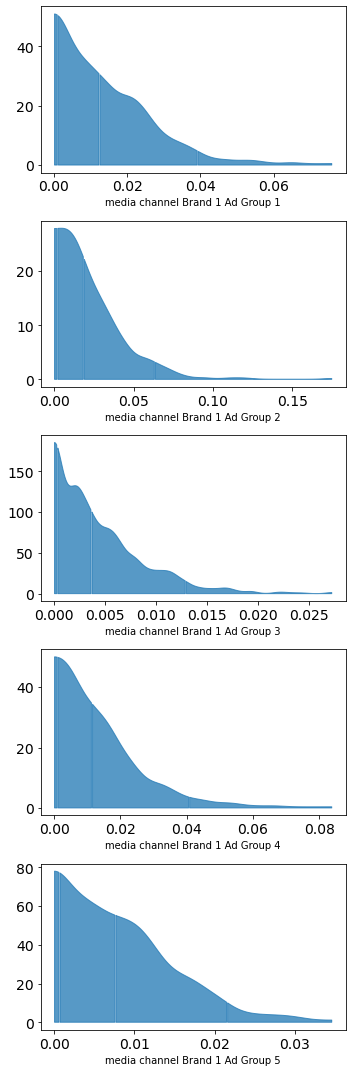

In [16]:
# 各説明変数の事後分布を可視化
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

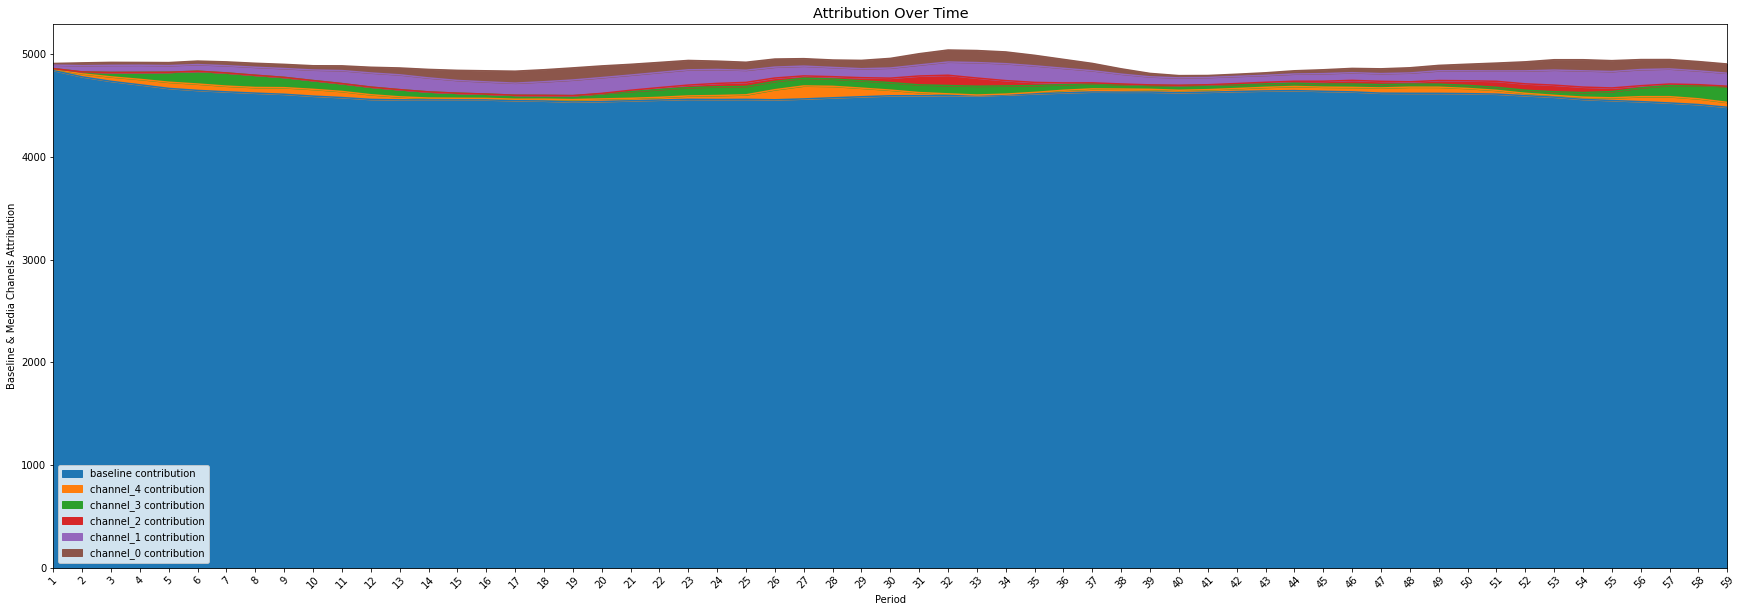

In [18]:
# 各施策の貢献度を可視化
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

In [19]:
# どの施策が有効なのかを可視化
media_effect_hat, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

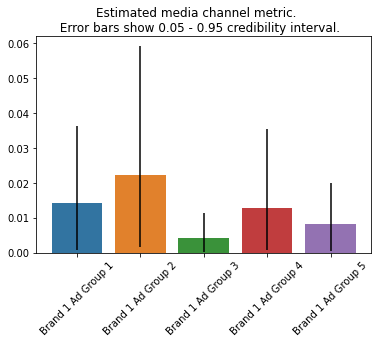

In [20]:
# 貢献度の可視化
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names)

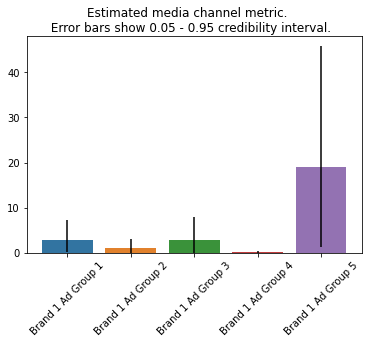

In [21]:
# ROIの可視化
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

In [22]:
SEED = 1

# NOTE: pricesはチューニングする必要がある(https://github.com/google/lightweight_mmm/discussions/15)
prices = jnp.ones(mmm.n_media_channels)

n_time_periods = 1
budget = jnp.sum(jnp.dot(prices, media_data_raw.values.mean(axis=0)))* n_time_periods

solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

# 最適な配分の計算
optimal_buget_allocation = prices * solution.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4997.407977072069
            Iterations: 27
            Function evaluations: 162
            Gradient evaluations: 27


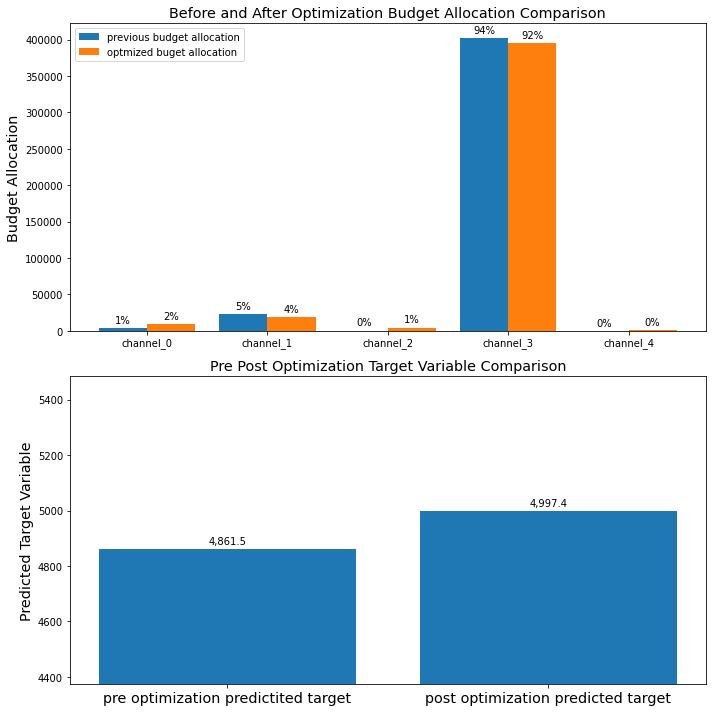

In [23]:
# 最適化前後の予算配分を可視化
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))